In [116]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, make_scorer, precision_score,recall_score, confusion_matrix, classification_report
import itertools
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt
import ast

In [117]:
data = pd.read_csv('core/cleveland.csv')
data_filtered= data.replace('?',pd.NA)
data_filtered = data_filtered.dropna()
data_filtered.num = data_filtered.num.apply(lambda x: 1 if x >0 else 0)
# One-hot encoding the 'cp' and 'restecg' features
data_filtered = pd.get_dummies(data_filtered, columns=['cp', 'restecg','slope','thal'], prefix=['cp', 'restecg','slope','thal'], drop_first=False, dtype=int)

In [118]:
corelated_feature=list(data_filtered.corr().num.apply(lambda x:abs(x)).sort_values(ascending =False).index[1:])

In [119]:
features = corelated_feature[0:11]

In [120]:
features.append('age')

In [121]:
combinations = []
feature_list = features
for r in range(4, len(feature_list) + 1):
    combinations.extend(itertools.combinations(feature_list, r))

combinations = [list(combo) for combo in combinations]

In [122]:
len(combinations)

3797

In [123]:
class CustomKNeighbors(BaseEstimator, ClassifierMixin):
    def __init__(self, n_neighbors):
        self.n_neighbors = n_neighbors

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        self.nn = NearestNeighbors(n_neighbors=self.n_neighbors)
        self.nn.fit(X)
        self.classes_ = np.unique(y)
        return self

    def predict(self, X):
        distances, indices = self.nn.kneighbors(X)
        predictions = []
        for idx in indices:
            neighbor_labels = self.y_train[idx]
            predicted_value = np.median(neighbor_labels)  # Calculate the median
            
            # Adjust the prediction based on the median value
            if predicted_value == 0.5:
                predictions.append(1)  # If median is 0.5, predict 1
            else:
                predictions.append(predicted_value)  # Otherwise, use the median
        return np.array(predictions)

## Note: This cell may take an hour to run. If you wish to skip it, please uncomment the next cell and execute it.

In [ ]:
results = []
columns = data_filtered.drop(columns='num').columns
feature_indices = {
    tuple(feature_combination): [columns.get_loc(col) for col in feature_combination]
    for feature_combination in combinations
}


X = data_filtered.drop(columns='num').values
y = data_filtered['num'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {'n_neighbors': np.arange(2, 41,2 )}
f1_scorer = make_scorer(f1_score, pos_label=1, greater_is_better=True)
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
count=0
for feature_combination, indices in feature_indices.items():
    X_train_subset = X_train_scaled[:, indices]
    X_test_subset = X_test_scaled[:, indices]

    custom_knn = CustomKNeighbors(n_neighbors=5)

    grid_search = GridSearchCV(custom_knn, param_grid, cv=skf, scoring=f1_scorer, verbose=0)
    grid_search.fit(X_train_subset, y_train)

    best_model = grid_search.best_estimator_
    count=count+1
    print(count)

    results.append({
        'feature_combination': feature_combination,
        'best_n_neighbors': grid_search.best_params_['n_neighbors'],
        'best_cv_score': grid_search.best_score_,
    })

knn_results = pd.DataFrame(results)
knn_results.to_csv('Knn_Results1.csv')
best_feature  = knn_results.iloc[knn_results.best_cv_score.idxmax()].feature_combination

### If you have already run the script above, you should not run the cell below. If you want to import the data, uncomment and run the cell below.

In [15]:
# knn_results = pd.read_csv('Knn_Results1.csv')
# best_feature = knn_results.iloc[knn_results.best_cv_score.idxmax()].feature_combination
# knn_results.iloc[knn_results.best_cv_score.idxmax()]
# best_feature = best_feature.strip("()").replace("'", "").split(", ") 

In [141]:
neighbor_results = pd.DataFrame(columns=np.arange(1, 41,1))
param_grid = {'n_neighbors': np.arange(1, 41, 1)}
skf = StratifiedKFold(n_splits=10, shuffle=True)
# Loop through 15 iterations
for iteration in range(1, 16):
    print(f"Iteration {iteration}")

    # Split the data (without using random_state to allow variation in splits)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # Scale the data
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Perform GridSearchCV to get the best neighbor count for this iteration
    grid_search = GridSearchCV(custom_knn, param_grid, cv=skf, scoring=f1_scorer, verbose=0)
    grid_search.fit(X_train_scaled, y_train)
    
    # Store the results in the dataframe for the current iteration
    iteration_results = pd.Series(grid_search.cv_results_['mean_test_score'], index=np.arange(1, 41))
    neighbor_results.loc[iteration] = iteration_results

    # Get and print the best n_neighbors for this iteration
    best_n_neighbors = grid_search.best_params_['n_neighbors']
    best_cv_score = grid_search.best_score_
    print(f'Best n_neighbors for iteration {iteration}: {best_n_neighbors}, Best CV score: {best_cv_score}')



Iteration 1
Best n_neighbors for iteration 1: 40, Best CV score: 0.8827471346350064
Iteration 2
Best n_neighbors for iteration 2: 30, Best CV score: 0.8668834966203388
Iteration 3
Best n_neighbors for iteration 3: 26, Best CV score: 0.8655580651232825
Iteration 4
Best n_neighbors for iteration 4: 31, Best CV score: 0.8399041080963278
Iteration 5
Best n_neighbors for iteration 5: 34, Best CV score: 0.825484038702507
Iteration 6
Best n_neighbors for iteration 6: 38, Best CV score: 0.8290193864106907
Iteration 7
Best n_neighbors for iteration 7: 40, Best CV score: 0.8286739576213261
Iteration 8
Best n_neighbors for iteration 8: 26, Best CV score: 0.8372233614338876
Iteration 9
Best n_neighbors for iteration 9: 30, Best CV score: 0.8652390462321812
Iteration 10
Best n_neighbors for iteration 10: 28, Best CV score: 0.8316746411483253
Iteration 11
Best n_neighbors for iteration 11: 36, Best CV score: 0.8461311612364243
Iteration 12
Best n_neighbors for iteration 12: 28, Best CV score: 0.8506

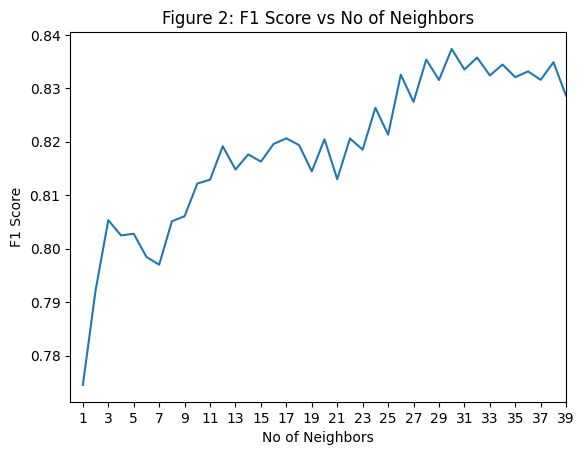

In [211]:
sns.lineplot( x = neighbor_results.mean().index, y = neighbor_results.mean().values)
plt.xlabel('No of Neighbors')
plt.ylabel('F1 Score')
plt.xlim(0,20)
plt.xticks(range(1, 41, 2))
plt.title('Figure 2: F1 Score vs No of Neighbors')
plt.savefig('nneighbour.png',dpi=300)

In [191]:
print(f'Optimal No of Neighbor = {neighbor_results.mean().idxmax()}')

Optimal No of Neighbor = 30


In [222]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
custom_knn = CustomKNeighbors(n_neighbors=30)
custom_knn.fit(X_train_scaled,y_train)
y_pred=custom_knn.predict(X_test_scaled)

In [ ]:
f1 = f1_score(y_test, y_pred, pos_label=1)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)


# Print the results
print(f'F1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True)

In [196]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93        36
           1       0.95      0.83      0.89        24

    accuracy                           0.92        60
   macro avg       0.92      0.90      0.91        60
weighted avg       0.92      0.92      0.92        60



In [197]:
sample_data = pd.read_csv('core/cleveland-test-sample.csv')
sample_data.replace('?', pd.NA, inplace=True)
sample_data.dropna(inplace=True)
sample_data.drop('Unnamed: 0',inplace=True, axis=1)
sample_data=pd.get_dummies(sample_data, columns=['cp', 'restecg','slope','thal'], prefix=['cp', 'restecg','slope','thal'], drop_first=False, dtype=int)
sample_data_X = sample_data.drop('disease', axis=1)[list(best_feature)].values
sample_data_y = sample_data.disease.values
sample_data_Xscaled = scaler.transform(sample_data_X)
sampe_data_ypredict=custom_knn.predict(sample_data_Xscaled)

In [218]:
f1 = f1_score(sample_data_y, sampe_data_ypredict, pos_label=1)
precision = precision_score(sample_data_y, sampe_data_ypredict, pos_label=1)
recall = recall_score(sample_data_y, sampe_data_ypredict, pos_label=1)

# Print the results
print(f'F1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(classification_report(sample_data_y,sampe_data_ypredict))

F1 Score: 0.9189
Precision: 0.8947
Recall: 0.9444
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           1       0.89      0.94      0.92        18

    accuracy                           0.92        39
   macro avg       0.92      0.92      0.92        39
weighted avg       0.92      0.92      0.92        39



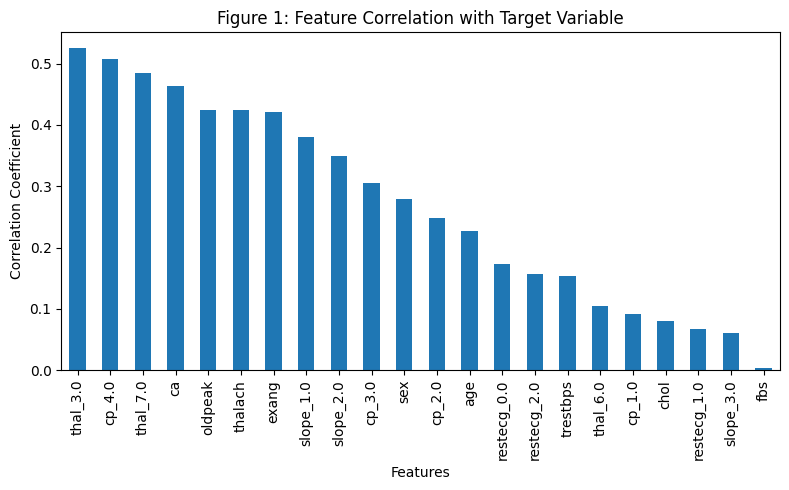

In [234]:
plt.figure(figsize=(8,5))
data_filtered.corr().num.apply(lambda x:abs(x)).sort_values(ascending =False).drop('num').plot(kind='bar')
plt.ylabel('Correlation Coefficient')
plt.xlabel('Features')

plt.title('Figure 1: Feature Correlation with Target Variable')
plt.tight_layout()
plt.savefig('correlation.png',dpi=300)

In [175]:
best_feature

('thal_3.0',
 'cp_4.0',
 'thal_7.0',
 'ca',
 'thalach',
 'exang',
 'slope_2.0',
 'age')